In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from typing import *
from sensetools.plots import feature_labeller

In [2]:
from scipy.stats import spearmanr
from collections import defaultdict

In [3]:
protein = '1fme'
lag = 41
top_n = -1


In [4]:
summary_paths = [f'../{protein}/summary_batch1.h5', f'../{protein}/summary_batch2.h5']
vamp_eqs = []
for summary_path in summary_paths:
    vamp_eqs.append(pd.read_hdf(summary_path, key='vamp_eqs'))
vamp_eqs = pd.concat(vamp_eqs)
# vamp_eqs.reset_index(inplace=True)

In [5]:
vamp_eqs['rank'] = vamp_eqs.groupby(['lag', 'process'])['median'].rank(ascending=False)

In [6]:
vamp_eqs = vamp_eqs.loc[(vamp_eqs.lag == lag) & (vamp_eqs.process < 22), : ]

In [7]:
def spearmans(df: pd.DataFrame, top: int = 95) -> pd.DataFrame: 
    procs = df.process.unique()
    n_procs = len(procs)
    results = defaultdict(list)
    if top == -1: 
        top = df['rank'].max()
#     ps = []
    for i in range(n_procs):
        i_proc = procs[i]
        i_keep_ix = df.loc[(df['rank'] <= top) & (df.process == i_proc), 'hp_ix'].values
        for j in range(n_procs): 
            j_proc = procs[j]
            
            j_keep_ix = df.loc[df.process  == j_proc, 'hp_ix']
            
            keep_ix = set(j_keep_ix).intersection(set(i_keep_ix))
            
            a = df.loc[(df.process == i_proc) & (df.hp_ix.isin(keep_ix)), 'median'].values
            b = df.loc[(df.process == j_proc) & (df.hp_ix.isin(keep_ix)), 'median'].values

            r, p = spearmanr(a, b)
            results['i_proc'].append(i_proc)
            results['j_proc'].append(j_proc)
            results['r'].append(r)
    df = pd.DataFrame(results)
    df = df.pivot_table(values='r', index='i_proc', columns='j_proc')
    return df

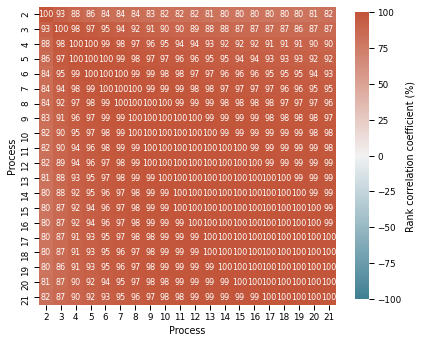

In [8]:
with sns.plotting_context('paper', font_scale=1):
    fig, axes = plt.subplots(1, 1, figsize=(6,6))
    ax = axes
    df = spearmans(vamp_eqs, top_n)


    sns.heatmap(df*100, ax=ax, vmin=-100, vmax=100, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), cbar=True, 
                annot_kws=dict(size='small'), square=True, fmt='2.0f', 
                cbar_kws=dict(shrink=0.7, label='Rank correlation coefficient (%)'))

    ax.set_xlabel('Process')
    ax.set_ylabel('Process')
                
    plt.tight_layout()
    plt.savefig(f'../{protein}/vampeq_rank_vs_proc.pdf', bbox_inches='tight')

In [10]:
df = vamp_eqs.loc[:, ['rank', 'process', 'hp_ix']]
df = df.loc[df.process < 22, : ]
col_vars = np.sort(df.process.unique())
col_vars = [f"Process {x}" for x in col_vars]
df['process'] = df['process'].apply(lambda x: f"Process {x}")

with sns.plotting_context('paper', font_scale=2): 
    g = sns.pairplot(df.pivot(index='hp_ix', columns='process', values='rank'), vars=col_vars, corner=True,diag_kind=None)

    plt.savefig(f'../{protein}/vampeq_rank_vs_proc_pairplot.pdf', bbox_inches='tight')      
    plt.close()